In [2]:
from elasticsearch import Elasticsearch
import pandas as pd

# Connexion à Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200,'scheme': 'http'}])

Print a sample

In [ ]:
resp = es.search(index="notes", query={"match_all": {}})
print("Got %d Hits:" % resp['hits']['total']['value'])
for hit in resp['hits']['hits'][0:7]:
    print(hit['_source'])

# 1- Répartition des sentiments par patient

In [ ]:
def get_sentiment_distribution(es,patient_firstname, patient_lastname):
    query = {
            "size": 10,
            "query": {
                "bool": {
                    "must": [
                        {"term": {"patient_firstname": patient_firstname}},
                        {"term": {"patient_lastname": patient_lastname}}
                    ]
                }
            },
            "aggs": {
                "sentiment_distribution": {
                    "terms": {"field": "emotion"}
                }
            }
        }
    

    response = es.search(index="notes", body=query)

    buckets = response["aggregations"]["sentiment_distribution"]["buckets"]

    df = pd.DataFrame(buckets, columns=["key", "doc_count"])
    return df

print(get_sentiment_distribution(es,'Samantha','Smith'))

# 2 - Matrice des sentiments contradictoires

In [6]:
def emotion_count(es,emotion):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        }
    }
   
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]


def get_happy_percentage(es,emotion,emotion_word):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        },
        "post_filter": {
            "match": {
                "text": emotion_word
            }
        }
    }

    
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]



get_happy_percentage(es,'happy','fear')
emotion_count(es,'happy')

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:32: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:32: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:11:

7606

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:11: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:32: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/231789638.py:32:

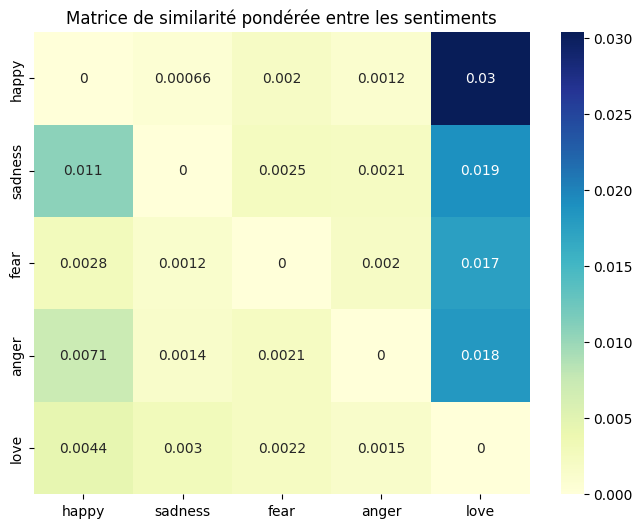

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

weighted_similarity_matrix = pd.DataFrame(0, index=['happy','sadness','fear','anger','love'], columns=['happy','sadness','fear','anger','love'])

for emotion1 in ['happy','sadness','fear','anger','love']:
    count_emotion1 = emotion_count(es,emotion1)
    for emotion2 in ['happy','sadness','fear','anger','love']:
        if emotion1!= emotion2:
            similarity = get_happy_percentage(es,emotion1,emotion2)/count_emotion1
            weighted_similarity_matrix.loc[emotion1, emotion2] = similarity

# Afficher la matrice de similarité pondérée sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_similarity_matrix, annot=True, cmap="YlGnBu")
plt.title("Matrice de similarité pondérée entre les sentiments")
plt.show()

#3- Etapes du deuil

In [11]:
def search_text_by_depression_stage(es,stage):
    query = {
        "size": 0,
        "query": {
            "match": {
                "text": stage
            }
        }
    }

    response = es.search(index="notes", body=query)
    total_docs = response["hits"]["total"]["value"]
    
    return total_docs


def fuzzy_search_text_by_depression_stage(es,stage):
    query = {
        "size": 0,
        "query": {
            "fuzzy": {
                "text": {
                    "value": stage,
                    "fuzziness": "AUTO"
                }
            }
        }
    }

    response = es.search(index="notes", body=query)
    total_docs = response["hits"]["total"]["value"]
    
    return total_docs

In [12]:
search_text_by_depression_stage(es,'denial')

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/1032775568.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/1032775568.py:11: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)


2

In [13]:
fuzzy_search_text_by_depression_stage(es,'denial')

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/1032775568.py:30: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/1032775568.py:30: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)


119

# 4- recherche avec plusieurs critères

In [15]:
def search_matching_texts(es):
    query = {
        "query": {
            "bool": {
                "must": [
                    {"match": {"text": "good day"}},
                    {"term": {"patient_left": False}}
                ],
                "should": [
                    {"match": {"text": "to rest"}}
                ],
                "filter": [
                    {"range": {"confidence": {"gte": 0.5}}}
                ]
            }
        }
    }

    response = es.search(index="notes", body=query)
    hits = response["hits"]["hits"]
    matching_texts = [hit["_source"]["text"] for hit in hits]
    
    return matching_texts

In [16]:
search_matching_texts(es)

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/496882350.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_52425/496882350.py:19: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)


['i either feel like crap about myself all day and try to make up for it the rest of the day and am exhausted',
 'i end up feeling groggy the rest of the day amp guilty that i didnt get anything done',
 'i am off on wednesday to a postgraduate open day but there will be plenty to write about the rest of the week i feel sure',
 'ive had where i feel good enough to work the whole shift possibly the whole day',
 'i feel so lame complaining that for minutes i get some blurry vision and then have to take it easy the rest of the day',
 'i worked out monday and tuesday but i was feeling so crappy on wednesday that i went home and decided to make it a rest day',
 'i know that obrian can do good characterisation as evidenced in his main characters it just feels like he couldnt be bothered to extend that to the rest of the crew',
 'i remember laying in the bath feeling really emotional knowing that i was going to bring my baby into the world on the day that miss cook was laid to rest',
 'i do fi